# DenseNet201 and Xception Models for ASD Detection on AutismDataset

Training DenseNet201 and Xception models for autism spectrum disorder detection using the AutismDataset.

## Models to be trained:
1. **DenseNet201** - Dense connections with efficient feature reuse
2. **Xception** - Depthwise separable convolutions for improved efficiency

These models will be adapted for autism spectrum disorder detection with proper fine-tuning and classification heads.

# Data Preprocessing and Setup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math
import glob
from sklearn.model_selection import train_test_split
import timm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## Model-Specific Transformations

DenseNet201 and Xception require specific preprocessing with ImageNet normalization.

In [2]:
# Standard ImageNet transformations for DenseNet201 and Xception (without augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Xception specific transforms (299x299 input, without augmentation)
xception_train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

xception_val_test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset Loading and Preprocessing

Loading the AutismDataset with the mixed folder structure we identified earlier.

In [3]:
def create_dataset_from_folders():
    """
    Create dataset from AutismDataset folder structure
    Returns train, validation, and test splits
    
    Dataset structure:
    - train/: Mixed files (Autistic.X.jpg and Non_Autistic.X.jpg)
    - test/: Mixed files (Autistic.X.jpg and Non_Autistic.X.jpg) 
    - valid/: Subdirectories (Autistic/ and Non_Autistic/)
    """
    base_path = '/kaggle/input/autism-image-data/AutismDataset'
    
    # Train and Test folders have mixed structure (files named by class)
    autistic_train = glob.glob(os.path.join(base_path, 'train', 'Autistic.*.jpg'))
    non_autistic_train = glob.glob(os.path.join(base_path, 'train', 'Non_Autistic.*.jpg'))
    
    autistic_test = glob.glob(os.path.join(base_path, 'test', 'Autistic.*.jpg'))
    non_autistic_test = glob.glob(os.path.join(base_path, 'test', 'Non_Autistic.*.jpg'))
    
    # Valid folder has subdirectory structure
    autistic_valid = glob.glob(os.path.join(base_path, 'valid', 'Autistic', '*.jpg'))
    non_autistic_valid = glob.glob(os.path.join(base_path, 'valid', 'Non_Autistic', '*.jpg'))
    
    # Create dataframes
    train_data = []
    train_data.extend([(path, 'Autistic') for path in autistic_train])
    train_data.extend([(path, 'Non_Autistic') for path in non_autistic_train])
    
    test_data = []
    test_data.extend([(path, 'Autistic') for path in autistic_test])
    test_data.extend([(path, 'Non_Autistic') for path in non_autistic_test])
    
    valid_data = []
    valid_data.extend([(path, 'Autistic') for path in autistic_valid])
    valid_data.extend([(path, 'Non_Autistic') for path in non_autistic_valid])
    
    # Convert to DataFrames
    train_df = pd.DataFrame(train_data, columns=['image_path', 'labels'])
    test_df = pd.DataFrame(test_data, columns=['image_path', 'labels'])
    valid_df = pd.DataFrame(valid_data, columns=['image_path', 'labels'])
    
    # Display dataset statistics
    print(f"Training samples: {len(train_df)}")
    print(f"  - Autistic: {len([x for x in train_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in train_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Validation samples: {len(valid_df)}")
    print(f"  - Autistic: {len([x for x in valid_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in valid_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Test samples: {len(test_df)}")
    print(f"  - Autistic: {len([x for x in test_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in test_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Classes: {train_df['labels'].unique()}")
    
    return train_df, valid_df, test_df

# Create the dataset
train_df, valid_df, test_df = create_dataset_from_folders()

Training samples: 2540
  - Autistic: 1270
  - Non_Autistic: 1270
Validation samples: 100
  - Autistic: 50
  - Non_Autistic: 50
Test samples: 300
  - Autistic: 150
  - Non_Autistic: 150
Classes: ['Autistic' 'Non_Autistic']


## Custom Dataset Class

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class AutismDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'image_path' and 'labels' columns
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['labels'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['labels'])
        
        self.image_paths = self.data['image_path'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Create a black placeholder image if file is missing/corrupted
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets with model-specific transforms
def create_datasets(train_df, val_df, test_df, transform_type='standard'):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    if transform_type == 'standard':
        train_transform_use = train_transform
        val_test_transform_use = val_test_transform
    elif transform_type == 'xception':
        train_transform_use = xception_train_transform
        val_test_transform_use = xception_val_test_transform
    else:
        raise ValueError("transform_type must be 'standard' or 'xception'")

    train_dataset = AutismDataset(
        dataframe=train_df, 
        transform=train_transform_use,
        fit_label_encoder=True  
    )
    
    le = train_dataset.get_label_encoder()
    
    val_dataset = AutismDataset(
        dataframe=val_df,
        transform=val_test_transform_use,
        label_encoder=le
    )
    
    test_dataset = AutismDataset(
        dataframe=test_df,
        transform=val_test_transform_use,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

# Model Architectures

## 1. DenseNet201 Model

In [7]:
def create_densenet201_model(num_classes=2, pretrained=True, dropout_rate=0.5):
    """
    Create DenseNet201 model with custom classification head
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
        dropout_rate (float): Dropout rate for regularization
    """
    # Load pretrained DenseNet201
    model = models.densenet201(pretrained=pretrained)
    
    # Get the number of features from the classifier
    num_features = model.classifier.in_features
    
    # Replace the classifier with our custom head
    model.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate/2),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate/4),
        nn.Linear(256, num_classes)
    )
    
    return model

## 2. Xception Model

In [8]:
def create_xception_model(num_classes=2, pretrained=True, dropout_rate=0.5):
    """
    Create Xception model using timm library
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
        dropout_rate (float): Dropout rate for regularization
    """
    # Load pretrained Xception from timm
    model = timm.create_model('xception', pretrained=pretrained, num_classes=0)  # num_classes=0 removes head
    
    # Get the number of features
    num_features = model.num_features
    
    # Add custom classification head
    model.head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate/2),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate/4),
        nn.Linear(256, num_classes)
    )
    
    # Wrap in a custom module to handle forward pass
    class XceptionWrapper(nn.Module):
        def __init__(self, base_model):
            super(XceptionWrapper, self).__init__()
            self.features = base_model
            self.head = base_model.head
            
        def forward(self, x):
            # Extract features (without head)
            x = self.features.forward_features(x)
            # Apply custom head
            x = self.head(x)
            return x
    
    return XceptionWrapper(model)

# Training and Evaluation Framework

In [9]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Store label encoder from dataset
        try:
            self.label_encoder = train_loader.dataset.get_label_encoder()
        except:
            self.label_encoder = None
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model"""
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
        
        # Best model tracking
        best_val_acc = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 10
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model
                if phase == 'val' and epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation accuracy: {best_val_acc:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step
            scheduler.step(best_val_acc)
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_val_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None):
        """Evaluate model on test set"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Get class names from label encoder if available
        try:
            if hasattr(self, 'label_encoder') and self.label_encoder:
                class_names = self.label_encoder.classes_
            else:
                class_names = self.train_loader.dataset.get_class_names()
        except:
            class_names = ['Autistic', 'Non_Autistic']
        
        print(f"Class names: {class_names}")
        
        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, 
                                  target_names=class_names,
                                  zero_division=0))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        return test_acc, all_preds, all_labels
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# GPU Configuration and Data Validation

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.89 GB


# Model Training Sections

## 1. DenseNet201 Model Training

In [11]:
# Create datasets for DenseNet201 (224x224 input)
print("Creating DenseNet201 datasets...")
densenet_train_dataset, densenet_val_dataset, densenet_test_dataset, densenet_label_encoder = create_datasets(
    train_df=train_df,
    val_df=valid_df, 
    test_df=test_df,
    transform_type='standard'
)

# Create dataloaders
densenet_train_loader, densenet_val_loader, densenet_test_loader = create_dataloaders(
    densenet_train_dataset, densenet_val_dataset, densenet_test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"\nDenseNet201 Dataset Summary:")
print(f"Training samples: {len(densenet_train_dataset)}")
print(f"Validation samples: {len(densenet_val_dataset)}")
print(f"Test samples: {len(densenet_test_dataset)}")
print(f"Classes: {densenet_label_encoder.classes_}")

# Test data loading
print("\nTesting DenseNet201 data loading...")
try:
    densenet_batch = next(iter(densenet_train_loader))
    print(f"✓ DenseNet201 batch shape: {densenet_batch[0].shape}, Labels: {densenet_batch[1].shape}")
    print("✓ DenseNet201 data loading successful!\n")
except Exception as e:
    print(f"✗ DenseNet201 data loading failed: {e}")
    raise e

Creating DenseNet201 datasets...

DenseNet201 Dataset Summary:
Training samples: 2540
Validation samples: 100
Test samples: 300
Classes: ['Autistic' 'Non_Autistic']

Testing DenseNet201 data loading...
✓ DenseNet201 batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✓ DenseNet201 data loading successful!



Creating DenseNet201 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 210MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

Training DenseNet201 model...
Starting training for 30 epochs...
------------------------------------------------------------
Epoch 1/30
----------


Train : 100%|██████████| 79/79 [00:24<00:00,  3.16it/s, Loss=0.5274, Acc=0.7275]


Train Loss: 0.5274 Acc: 0.7275


Val : 100%|██████████| 4/4 [00:00<00:00,  4.00it/s, Loss=0.4801, Acc=0.7100]


Val Loss: 0.4801 Acc: 0.7100
✓ New best model saved with validation accuracy: 0.7100

Epoch 2/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.38it/s, Loss=0.2589, Acc=0.8983]


Train Loss: 0.2589 Acc: 0.8983


Val : 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, Loss=0.4674, Acc=0.8300]


Val Loss: 0.4674 Acc: 0.8300
✓ New best model saved with validation accuracy: 0.8300

Epoch 3/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.38it/s, Loss=0.1225, Acc=0.9604]


Train Loss: 0.1225 Acc: 0.9604


Val : 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Loss=0.5096, Acc=0.8200]


Val Loss: 0.5096 Acc: 0.8200

Epoch 4/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0568, Acc=0.9862]


Train Loss: 0.0568 Acc: 0.9862


Val : 100%|██████████| 4/4 [00:00<00:00,  5.61it/s, Loss=0.5575, Acc=0.8000]


Val Loss: 0.5575 Acc: 0.8000

Epoch 5/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.37it/s, Loss=0.0546, Acc=0.9846]


Train Loss: 0.0546 Acc: 0.9846


Val : 100%|██████████| 4/4 [00:00<00:00,  5.76it/s, Loss=0.4441, Acc=0.8600]


Val Loss: 0.4441 Acc: 0.8600
✓ New best model saved with validation accuracy: 0.8600

Epoch 6/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0464, Acc=0.9869]


Train Loss: 0.0464 Acc: 0.9869


Val : 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Loss=0.5267, Acc=0.8100]


Val Loss: 0.5267 Acc: 0.8100

Epoch 7/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.38it/s, Loss=0.0667, Acc=0.9763]


Train Loss: 0.0667 Acc: 0.9763


Val : 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Loss=0.4119, Acc=0.8400]


Val Loss: 0.4119 Acc: 0.8400

Epoch 8/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0783, Acc=0.9715]


Train Loss: 0.0783 Acc: 0.9715


Val : 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, Loss=0.3102, Acc=0.8400]


Val Loss: 0.3102 Acc: 0.8400

Epoch 9/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.38it/s, Loss=0.0355, Acc=0.9925]


Train Loss: 0.0355 Acc: 0.9925


Val : 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, Loss=0.3563, Acc=0.8700]


Val Loss: 0.3563 Acc: 0.8700
✓ New best model saved with validation accuracy: 0.8700

Epoch 10/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0256, Acc=0.9921]


Train Loss: 0.0256 Acc: 0.9921


Val : 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Loss=0.5105, Acc=0.8600]


Val Loss: 0.5105 Acc: 0.8600

Epoch 11/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0296, Acc=0.9905]


Train Loss: 0.0296 Acc: 0.9905


Val : 100%|██████████| 4/4 [00:00<00:00,  5.54it/s, Loss=0.6243, Acc=0.8200]


Val Loss: 0.6243 Acc: 0.8200

Epoch 12/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0346, Acc=0.9877]


Train Loss: 0.0346 Acc: 0.9877


Val : 100%|██████████| 4/4 [00:00<00:00,  5.68it/s, Loss=0.4922, Acc=0.8300]


Val Loss: 0.4922 Acc: 0.8300

Epoch 13/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.35it/s, Loss=0.0268, Acc=0.9917]


Train Loss: 0.0268 Acc: 0.9917


Val : 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, Loss=0.7181, Acc=0.8200]


Val Loss: 0.7181 Acc: 0.8200

Epoch 14/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0445, Acc=0.9869]


Train Loss: 0.0445 Acc: 0.9869


Val : 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, Loss=0.5763, Acc=0.8600]


Val Loss: 0.5763 Acc: 0.8600

Epoch 15/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0373, Acc=0.9850]


Train Loss: 0.0373 Acc: 0.9850


Val : 100%|██████████| 4/4 [00:00<00:00,  5.78it/s, Loss=0.5452, Acc=0.8200]


Val Loss: 0.5452 Acc: 0.8200

Epoch 16/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.38it/s, Loss=0.0225, Acc=0.9945]


Train Loss: 0.0225 Acc: 0.9945


Val : 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, Loss=0.4687, Acc=0.8600]


Val Loss: 0.4687 Acc: 0.8600

Epoch 17/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0087, Acc=0.9988]


Train Loss: 0.0087 Acc: 0.9988


Val : 100%|██████████| 4/4 [00:00<00:00,  5.55it/s, Loss=0.5407, Acc=0.8200]


Val Loss: 0.5407 Acc: 0.8200

Epoch 18/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0066, Acc=0.9988]


Train Loss: 0.0066 Acc: 0.9988


Val : 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, Loss=0.4994, Acc=0.8600]


Val Loss: 0.4994 Acc: 0.8600

Epoch 19/30
----------


Train : 100%|██████████| 79/79 [00:23<00:00,  3.39it/s, Loss=0.0049, Acc=1.0000]


Train Loss: 0.0049 Acc: 1.0000


Val : 100%|██████████| 4/4 [00:00<00:00,  5.50it/s, Loss=0.5475, Acc=0.8300]


Val Loss: 0.5475 Acc: 0.8300
Early stopping triggered after 19 epochs
Training complete in 7m 40s
Best validation accuracy: 0.8700
Evaluating DenseNet201 model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Test Accuracy: 91.33%
Test Loss: 0.2628
Class names: ['Autistic' 'Non_Autistic']

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.91      0.92      0.91       150
Non_Autistic       0.92      0.91      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300


Confusion Matrix:
[[138  12]
 [ 14 136]]
Plotting DenseNet201 training history...


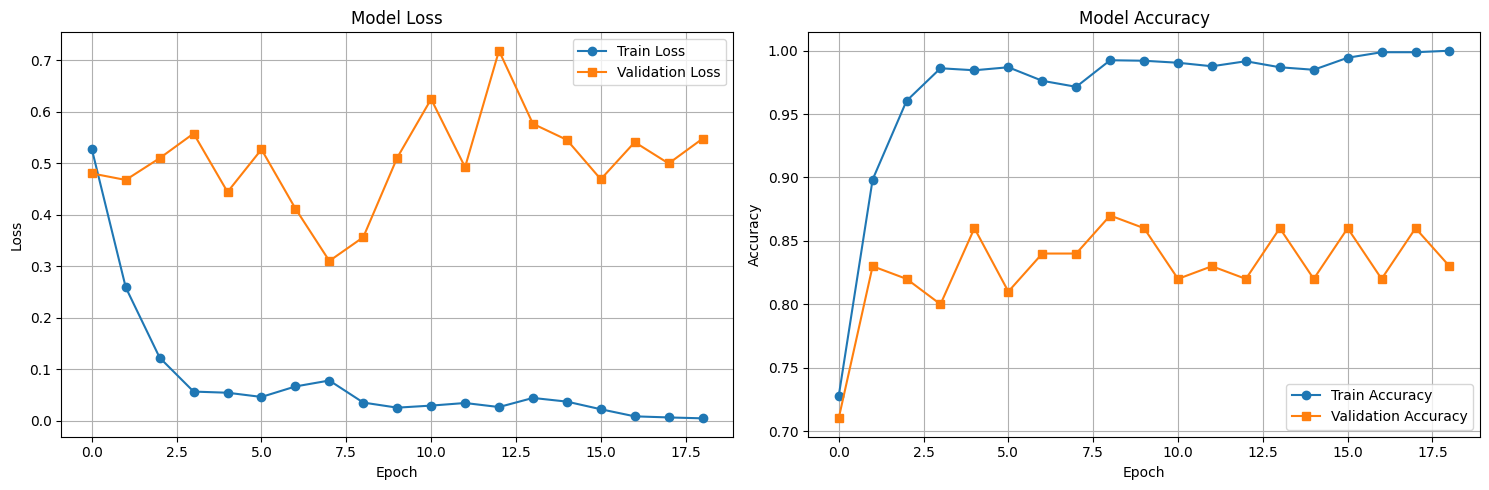

In [12]:
# Create and train DenseNet201 model
print("Creating DenseNet201 model...")
densenet201_model = create_densenet201_model(num_classes=2, pretrained=True, dropout_rate=0.5)
densenet201_trainer = ModelTrainer(densenet201_model, densenet_train_loader, densenet_val_loader, densenet_test_loader, device)

print("Training DenseNet201 model...")
trained_densenet201 = densenet201_trainer.train_model(num_epochs=30, lr=0.0001, model_name="densenet201_autism")

print("Evaluating DenseNet201 model...")
densenet201_test_acc, densenet201_preds, densenet201_labels = densenet201_trainer.evaluate_model()

print("Plotting DenseNet201 training history...")
densenet201_trainer.plot_training_history()

## 2. Xception Model Training

In [13]:
# Create datasets for Xception (299x299 input)
print("Creating Xception datasets...")
xception_train_dataset, xception_val_dataset, xception_test_dataset, xception_label_encoder = create_datasets(
    train_df=train_df,
    val_df=valid_df, 
    test_df=test_df,
    transform_type='xception'
)

# Create dataloaders
xception_train_loader, xception_val_loader, xception_test_loader = create_dataloaders(
    xception_train_dataset, xception_val_dataset, xception_test_dataset, 
    batch_size=16,  # Smaller batch size for Xception due to memory requirements
    num_workers=4
)

print(f"\nXception Dataset Summary:")
print(f"Training samples: {len(xception_train_dataset)}")
print(f"Validation samples: {len(xception_val_dataset)}")
print(f"Test samples: {len(xception_test_dataset)}")
print(f"Classes: {xception_label_encoder.classes_}")

# Test data loading
print("\nTesting Xception data loading...")
try:
    xception_batch = next(iter(xception_train_loader))
    print(f"✓ Xception batch shape: {xception_batch[0].shape}, Labels: {xception_batch[1].shape}")
    print("✓ Xception data loading successful!\n")
except Exception as e:
    print(f"✗ Xception data loading failed: {e}")
    raise e

Creating Xception datasets...

Xception Dataset Summary:
Training samples: 2540
Validation samples: 100
Test samples: 300
Classes: ['Autistic' 'Non_Autistic']

Testing Xception data loading...
✓ Xception batch shape: torch.Size([16, 3, 299, 299]), Labels: torch.Size([16])
✓ Xception data loading successful!



Creating Xception model...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Xception model...
Starting training for 30 epochs...
------------------------------------------------------------
Epoch 1/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.79it/s, Loss=0.4885, Acc=0.7595]


Train Loss: 0.4885 Acc: 0.7595


Val : 100%|██████████| 7/7 [00:00<00:00,  8.68it/s, Loss=0.5053, Acc=0.7600]


Val Loss: 0.5053 Acc: 0.7600
✓ New best model saved with validation accuracy: 0.7600

Epoch 2/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.79it/s, Loss=0.2629, Acc=0.8991]


Train Loss: 0.2629 Acc: 0.8991


Val : 100%|██████████| 7/7 [00:00<00:00,  8.26it/s, Loss=0.4792, Acc=0.7800]


Val Loss: 0.4792 Acc: 0.7800
✓ New best model saved with validation accuracy: 0.7800

Epoch 3/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.1224, Acc=0.9616]


Train Loss: 0.1224 Acc: 0.9616


Val : 100%|██████████| 7/7 [00:00<00:00,  8.63it/s, Loss=0.5948, Acc=0.7500]


Val Loss: 0.5948 Acc: 0.7500

Epoch 4/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0791, Acc=0.9775]


Train Loss: 0.0791 Acc: 0.9775


Val : 100%|██████████| 7/7 [00:00<00:00,  8.89it/s, Loss=0.4997, Acc=0.7900]


Val Loss: 0.4997 Acc: 0.7900
✓ New best model saved with validation accuracy: 0.7900

Epoch 5/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0436, Acc=0.9869]


Train Loss: 0.0436 Acc: 0.9869


Val : 100%|██████████| 7/7 [00:00<00:00,  8.80it/s, Loss=0.4537, Acc=0.8200]


Val Loss: 0.4537 Acc: 0.8200
✓ New best model saved with validation accuracy: 0.8200

Epoch 6/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0480, Acc=0.9850]


Train Loss: 0.0480 Acc: 0.9850


Val : 100%|██████████| 7/7 [00:00<00:00,  8.65it/s, Loss=0.6071, Acc=0.7700]


Val Loss: 0.6071 Acc: 0.7700

Epoch 7/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0815, Acc=0.9739]


Train Loss: 0.0815 Acc: 0.9739


Val : 100%|██████████| 7/7 [00:00<00:00,  8.76it/s, Loss=0.5516, Acc=0.8100]


Val Loss: 0.5516 Acc: 0.8100

Epoch 8/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0709, Acc=0.9767]


Train Loss: 0.0709 Acc: 0.9767


Val : 100%|██████████| 7/7 [00:00<00:00,  8.62it/s, Loss=0.6972, Acc=0.7700]


Val Loss: 0.6972 Acc: 0.7700

Epoch 9/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0434, Acc=0.9858]


Train Loss: 0.0434 Acc: 0.9858


Val : 100%|██████████| 7/7 [00:00<00:00,  8.62it/s, Loss=0.6587, Acc=0.8200]


Val Loss: 0.6587 Acc: 0.8200

Epoch 10/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.79it/s, Loss=0.0420, Acc=0.9881]


Train Loss: 0.0420 Acc: 0.9881


Val : 100%|██████████| 7/7 [00:00<00:00,  8.58it/s, Loss=0.5567, Acc=0.8200]


Val Loss: 0.5567 Acc: 0.8200

Epoch 11/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0424, Acc=0.9866]


Train Loss: 0.0424 Acc: 0.9866


Val : 100%|██████████| 7/7 [00:00<00:00,  8.60it/s, Loss=0.6901, Acc=0.8000]


Val Loss: 0.6901 Acc: 0.8000

Epoch 12/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0314, Acc=0.9917]


Train Loss: 0.0314 Acc: 0.9917


Val : 100%|██████████| 7/7 [00:00<00:00,  8.63it/s, Loss=0.5977, Acc=0.8000]


Val Loss: 0.5977 Acc: 0.8000

Epoch 13/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0155, Acc=0.9960]


Train Loss: 0.0155 Acc: 0.9960


Val : 100%|██████████| 7/7 [00:00<00:00,  8.79it/s, Loss=0.6405, Acc=0.8200]


Val Loss: 0.6405 Acc: 0.8200

Epoch 14/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0129, Acc=0.9984]


Train Loss: 0.0129 Acc: 0.9984


Val : 100%|██████████| 7/7 [00:00<00:00,  8.69it/s, Loss=0.6351, Acc=0.8300]


Val Loss: 0.6351 Acc: 0.8300
✓ New best model saved with validation accuracy: 0.8300

Epoch 15/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.79it/s, Loss=0.0116, Acc=0.9972]


Train Loss: 0.0116 Acc: 0.9972


Val : 100%|██████████| 7/7 [00:00<00:00,  8.59it/s, Loss=0.8194, Acc=0.7900]


Val Loss: 0.8194 Acc: 0.7900

Epoch 16/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0088, Acc=0.9980]


Train Loss: 0.0088 Acc: 0.9980


Val : 100%|██████████| 7/7 [00:00<00:00,  8.65it/s, Loss=0.6520, Acc=0.8400]


Val Loss: 0.6520 Acc: 0.8400
✓ New best model saved with validation accuracy: 0.8400

Epoch 17/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.79it/s, Loss=0.0057, Acc=0.9992]


Train Loss: 0.0057 Acc: 0.9992


Val : 100%|██████████| 7/7 [00:00<00:00,  8.56it/s, Loss=0.5799, Acc=0.8500]


Val Loss: 0.5799 Acc: 0.8500
✓ New best model saved with validation accuracy: 0.8500

Epoch 18/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.79it/s, Loss=0.0101, Acc=0.9972]


Train Loss: 0.0101 Acc: 0.9972


Val : 100%|██████████| 7/7 [00:00<00:00,  8.85it/s, Loss=0.9070, Acc=0.7600]


Val Loss: 0.9070 Acc: 0.7600

Epoch 19/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0079, Acc=0.9976]


Train Loss: 0.0079 Acc: 0.9976


Val : 100%|██████████| 7/7 [00:00<00:00,  8.54it/s, Loss=0.7592, Acc=0.8300]


Val Loss: 0.7592 Acc: 0.8300

Epoch 20/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0110, Acc=0.9956]


Train Loss: 0.0110 Acc: 0.9956


Val : 100%|██████████| 7/7 [00:00<00:00,  8.56it/s, Loss=0.6673, Acc=0.8300]


Val Loss: 0.6673 Acc: 0.8300

Epoch 21/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0104, Acc=0.9968]


Train Loss: 0.0104 Acc: 0.9968


Val : 100%|██████████| 7/7 [00:00<00:00,  8.61it/s, Loss=0.6748, Acc=0.8200]


Val Loss: 0.6748 Acc: 0.8200

Epoch 22/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0038, Acc=0.9996]


Train Loss: 0.0038 Acc: 0.9996


Val : 100%|██████████| 7/7 [00:00<00:00,  8.21it/s, Loss=0.7401, Acc=0.8200]


Val Loss: 0.7401 Acc: 0.8200

Epoch 23/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0073, Acc=0.9976]


Train Loss: 0.0073 Acc: 0.9976


Val : 100%|██████████| 7/7 [00:00<00:00,  8.70it/s, Loss=0.8981, Acc=0.8100]


Val Loss: 0.8981 Acc: 0.8100

Epoch 24/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0029, Acc=0.9996]


Train Loss: 0.0029 Acc: 0.9996


Val : 100%|██████████| 7/7 [00:00<00:00,  8.62it/s, Loss=0.7569, Acc=0.8300]


Val Loss: 0.7569 Acc: 0.8300

Epoch 25/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0022, Acc=1.0000]


Train Loss: 0.0022 Acc: 1.0000


Val : 100%|██████████| 7/7 [00:00<00:00,  8.75it/s, Loss=0.8503, Acc=0.8200]


Val Loss: 0.8503 Acc: 0.8200

Epoch 26/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0019, Acc=1.0000]


Train Loss: 0.0019 Acc: 1.0000


Val : 100%|██████████| 7/7 [00:00<00:00,  8.68it/s, Loss=0.8891, Acc=0.8200]


Val Loss: 0.8891 Acc: 0.8200

Epoch 27/30
----------


Train : 100%|██████████| 158/158 [00:41<00:00,  3.80it/s, Loss=0.0068, Acc=0.9988]


Train Loss: 0.0068 Acc: 0.9988


Val : 100%|██████████| 7/7 [00:00<00:00,  8.96it/s, Loss=0.8632, Acc=0.8200]


Val Loss: 0.8632 Acc: 0.8200
Early stopping triggered after 27 epochs
Training complete in 19m 7s
Best validation accuracy: 0.8500
Evaluating Xception model...
Evaluating on test set...


100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


Test Accuracy: 90.67%
Test Loss: 0.3319
Class names: ['Autistic' 'Non_Autistic']

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.88      0.94      0.91       150
Non_Autistic       0.94      0.87      0.90       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300


Confusion Matrix:
[[141   9]
 [ 19 131]]
Plotting Xception training history...


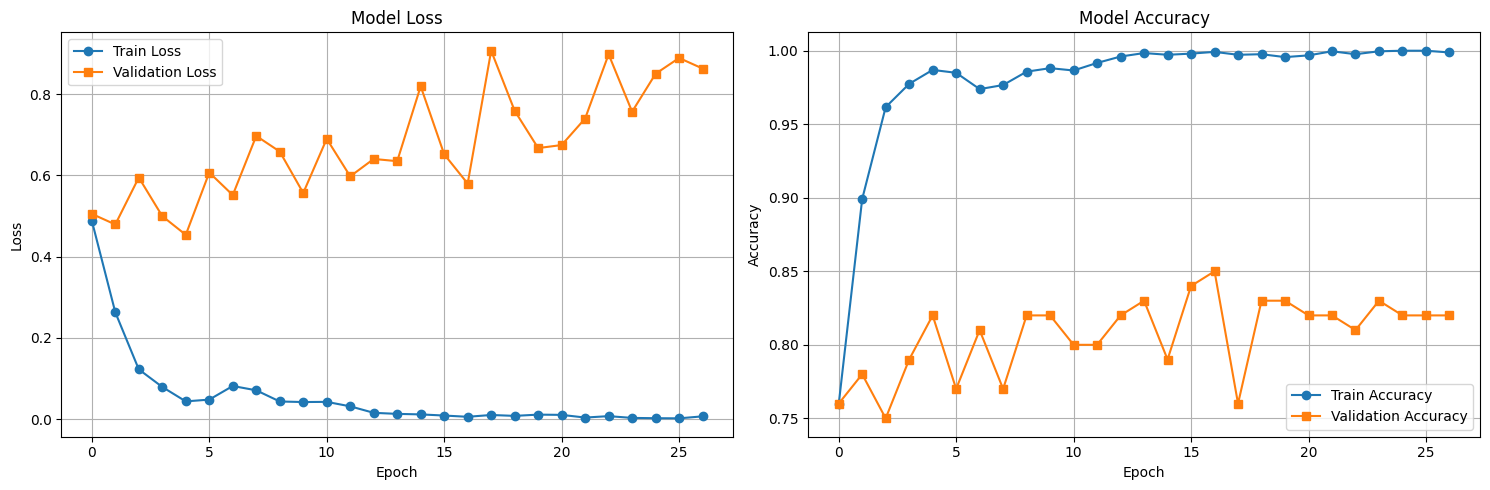

In [14]:
# Create and train Xception model
print("Creating Xception model...")
xception_model = create_xception_model(num_classes=2, pretrained=True, dropout_rate=0.5)
xception_trainer = ModelTrainer(xception_model, xception_train_loader, xception_val_loader, xception_test_loader, device)

print("Training Xception model...")
trained_xception = xception_trainer.train_model(num_epochs=30, lr=0.0001, model_name="xception_autism")

print("Evaluating Xception model...")
xception_test_acc, xception_preds, xception_labels = xception_trainer.evaluate_model()

print("Plotting Xception training history...")
xception_trainer.plot_training_history()

# Results Summary and Model Comparison

AUTISM DATASET - DENSENET201 & XCEPTION MODELS PERFORMANCE SUMMARY
Model                Test Accuracy (%)
------------------------------------------------------------
DenseNet201          91.33          
Xception             90.67          

TOP PERFORMING MODELS:
      Model  Test Accuracy
DenseNet201      91.333333
   Xception      90.666667


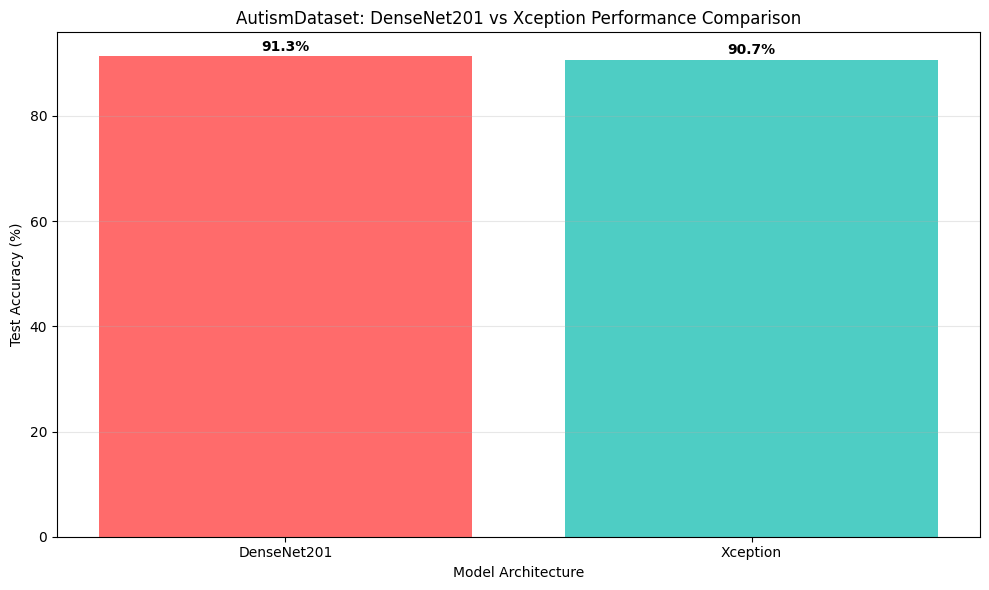


DenseNet201 and Xception model training completed!
Results saved to 'autism_dataset_densenet_xception_results.csv'

MODEL CHARACTERISTICS:
DenseNet201:
  - Architecture: Densely Connected Convolutional Networks
  - Input Size: 224x224
  - Parameters: ~20M
  - Key Feature: Dense connections for feature reuse
  - Strength: Efficient parameter usage, gradient flow

Xception:
  - Architecture: Extreme Inception with Depthwise Separable Convolutions
  - Input Size: 299x299
  - Parameters: ~23M
  - Key Feature: Depthwise separable convolutions
  - Strength: Efficient computation, good feature extraction


In [15]:
# Create a comprehensive results table for DenseNet201 and Xception models
results_data = []

# Collect all results
model_results = [
    ("DenseNet201", "densenet201_test_acc"),
    ("Xception", "xception_test_acc")
]

print("=" * 60)
print("AUTISM DATASET - DENSENET201 & XCEPTION MODELS PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'Test Accuracy (%)':<15}")
print("-" * 60)

for model_name, acc_var in model_results:
    try:
        accuracy = eval(acc_var)
        print(f"{model_name:<20} {accuracy:<15.2f}")
        results_data.append({"Model": model_name, "Test Accuracy": accuracy})
    except NameError:
        print(f"{model_name:<20} {'Not Available':<15}")

# Create results DataFrame and save
if results_data:
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('Test Accuracy', ascending=False)
    results_df.to_csv('autism_dataset_densenet_xception_results.csv', index=False)
    
    print("\n" + "=" * 60)
    print("TOP PERFORMING MODELS:")
    print("=" * 60)
    print(results_df.to_string(index=False))
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    bars = plt.bar(results_df['Model'], results_df['Test Accuracy'], 
                   color=['#FF6B6B', '#4ECDC4'])
    plt.xlabel('Model Architecture')
    plt.ylabel('Test Accuracy (%)')
    plt.title('AutismDataset: DenseNet201 vs Xception Performance Comparison')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('autism_dataset_densenet_xception_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nDenseNet201 and Xception model training completed!")
print("Results saved to 'autism_dataset_densenet_xception_results.csv'")

# Display model characteristics
print("\n" + "=" * 60)
print("MODEL CHARACTERISTICS:")
print("=" * 60)
print("DenseNet201:")
print("  - Architecture: Densely Connected Convolutional Networks")
print("  - Input Size: 224x224")
print("  - Parameters: ~20M")
print("  - Key Feature: Dense connections for feature reuse")
print("  - Strength: Efficient parameter usage, gradient flow")

print("\nXception:")
print("  - Architecture: Extreme Inception with Depthwise Separable Convolutions")
print("  - Input Size: 299x299")
print("  - Parameters: ~23M")
print("  - Key Feature: Depthwise separable convolutions")
print("  - Strength: Efficient computation, good feature extraction")